<a href="https://colab.research.google.com/github/luozegithub/torch_project/blob/master/neural-style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import PIL.Image as Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

img_size = 512
loader = transforms.Compose([
        transforms.Resize([ img_size,img_size]), 
        transforms.ToTensor()
#     ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

]) 
unloader = transforms.ToPILImage()  # reconvert into PIL image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_img(img_path):
    img = Image.open(img_path).convert('RGB')
    img = loader(img).unsqueeze(0)
    return img.to(device, torch.float)



def show_img(tensor,title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  
    image = image.squeeze(0) # torch.Size([3, 512, 512]) 去掉之前unsqueeze添加的维度
    image = unloader(image)
  
    if title is not None:
        plt.title(title)
    plt.pause(1) # pause a bit so that plots are updated
    plt.imshow(image)

In [0]:



class Content_Loss(nn.Module):
    def __init__(self, target, weight):
        super(Content_Loss, self).__init__()
        self.weight = weight


        self.target = target.detach() * self.weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        out = input.clone()
        return out
# retain_graph就是用来保存计算反向时的graph的，当retain_graph为true时，那么就可以多次单独backward，而不怕上一次的梯度消失！
    def backward(self, retain_variabels=True):
        self.loss.backward(retain_graph=True)
        return self.loss


      
# 为了计算styleloss 我们设计了Gram矩阵
'''
Gram矩阵是在这个特征图上定义的。每个特征图的大小一般是 MxNxC 或者是 CxMxN，

Gram矩阵是如何定义的呢？首先Gram矩阵的大小是有特征图的channel 决定的，等于 CxC，那么每一个Gram矩阵的元素，也就是 Gram(i, j) 等于多少呢？先把特征图中第 i 层和第 j 层取出来，
这样就得到了两个 MxN的矩阵，然后将这两个矩阵对应元素相乘然后求和就得到了 Gram(i, j)，同理 Gram 的所有元素都可以通过这个方式得到。这样 Gram 中每个元素都可以表示两层特征图的一种组合，就可以定义为它的风格。
实现的时候我们直接使用view将其变化成(c，（h*w）),然后乘以转置矩阵得到最终结果

然后风格的差异就是两幅图的 Gram 矩阵的差异，就像内容的差异的计算方法一样，计算一下这两个矩阵的差就可以量化风格的差异。
'''
class Gram(nn.Module):
    def __init__(self):
        super(Gram, self).__init__()

    def forward(self, input):
        a, b, c, d = input.size()
        feature = input.view(a * b, c * d)
        gram = torch.mm(feature, feature.t())
        gram /= (a * b * c * d)
        return gram


class Style_Loss(nn.Module):
    def __init__(self, target, weight):
        super(Style_Loss, self).__init__()
        self.weight = weight
        # 因为这里的target是用style图传入网络中得到的。它是一个Variable！有着自己的计算图。detach()的作用就是将这个结点“截断”，使得其变成叶子节点
        # 截断反向传播的梯度流
        self.target = target.detach() * self.weight
        self.gram = Gram()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        G = self.gram(input) * self.weight
        self.loss = self.criterion(G, self.target)
        out = input.clone()
        return out

    def backward(self, retain_variabels=True):
        self.loss.backward(retain_graph=True)
        return self.loss


In [0]:
import torch.nn as nn
import torchvision.models as models


vgg = models.vgg19(pretrained=True).features
vgg = vgg.cuda()

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_loss(style_img,
                             content_img,
                             cnn=vgg,
                             style_weight=1000,
                             content_weight=1,
                             content_layers=content_layers_default,
                             style_layers=style_layers_default):

    content_loss_list = []
    style_loss_list = []

    model = nn.Sequential()

    model = model.cuda()
    gram = Gram()
    gram = gram.cuda()

    i = 1
    for layer in cnn:
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)

            if name in content_layers_default:
                target = model(content_img)
                content_loss = Content_Loss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_loss_list.append(content_loss)

            if name in style_layers_default:
                target = model(style_img)
                target = gram(target)
                style_loss = Style_Loss(target, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_loss_list.append(style_loss)

            i += 1
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)

        if isinstance(layer, nn.ReLU):
            name = 'relu' + str(i)
            model.add_module(name, layer)

# now we trim off the layers after the last content and style losses
#     for i in range(len(model) - 1, -1, -1):
#         if isinstance(model[i], Content_Loss) or isinstance(model[i], Style_Loss):
#             break
#     model = model[:(i + 1)]

# 将整个模型，以及损失层的list全部返回
    return model, style_loss_list, content_loss_list


In [0]:
import torch.nn as nn
import torch.optim as optim




def get_input_param_optimier(input_img):
    """
    input_img is a Variable
    """
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer


def run_style_transfer(content_img, style_img, input_img, num_epoches=300):
    print('Building the style transfer model..')
    model, style_loss_list, content_loss_list = get_style_model_and_loss(
        style_img, content_img)
    input_param, optimizer = get_input_param_optimier(input_img)

    print('Opimizing...')
    epoch = [0]
    while epoch[0] <= num_epoches:

        def closure():
            input_param.data.clamp_(0, 1)

            model(input_param)
            style_score = 0
            content_score = 0
            # 首先梯度置0
            optimizer.zero_grad()
            

            '''

            其实这个“backward”只是一个普通的函数！并不是重载内部的backward！ 
            在这个“backward”中主要是调用criterion的backward，然后返回这个loss，
            好让外面能拿到相应的损失。 

            '''
            for sl in style_loss_list:
                style_score += sl.backward()
            # content层与style层甚至可以分开来backward！
            for cl in content_loss_list:
                content_score += cl.backward()

            epoch[0] += 1
            if epoch[0] % 50 == 0:
                print('run {}'.format(epoch))
                print('Style Loss: {:.4f} Content Loss: {:.4f}'.format(
                    style_score.data.item(), content_score.data.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
        
        # a last correction...
        input_param.data.clamp_(0, 1)

    return input_param.data


In [15]:
style_img = load_img('./style.png')

content_img = load_img('./content.png')

input_img = content_img.clone()
out = run_style_transfer(content_img, style_img, input_img, num_epoches=300)


# Style Loss: 0.3079 Content Loss: 5.1049

Building the style transfer model..
Opimizing...
run [50]
Style Loss: 2.7745 Content Loss: 5.8544

run [100]
Style Loss: 0.5561 Content Loss: 5.5692

run [150]
Style Loss: 0.4106 Content Loss: 5.2504

run [200]
Style Loss: 0.6102 Content Loss: 5.0544

run [250]
Style Loss: 0.2579 Content Loss: 5.0292

run [300]
Style Loss: 0.2123 Content Loss: 4.9905



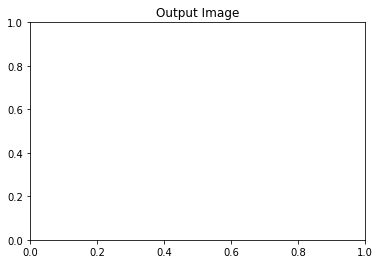

tensor([[[[0.8433, 0.8815, 0.9407,  ..., 0.9665, 0.9970, 0.8458],
          [0.9916, 0.9822, 0.9943,  ..., 0.9834, 0.9891, 0.9975],
          [0.9668, 0.9943, 0.9837,  ..., 0.9878, 0.9739, 0.9983],
          ...,
          [0.8771, 0.9536, 0.9001,  ..., 0.5952, 0.6440, 0.6343],
          [0.4727, 0.8534, 0.9983,  ..., 0.7485, 0.9702, 0.7681],
          [0.3301, 0.2657, 0.6823,  ..., 0.5352, 0.6275, 0.2642]],

         [[0.9988, 0.9958, 0.9968,  ..., 0.9922, 0.9945, 0.9555],
          [0.9883, 0.9795, 0.9997,  ..., 0.8743, 0.9127, 0.9929],
          [0.9984, 0.9980, 0.9631,  ..., 0.9812, 0.9620, 0.9928],
          ...,
          [0.8457, 0.9054, 0.6918,  ..., 0.6107, 0.6096, 0.8544],
          [0.3934, 0.9110, 0.9477,  ..., 0.7786, 0.9827, 0.9210],
          [0.3859, 0.4815, 0.7928,  ..., 0.6700, 0.7220, 0.2989]],

         [[0.9973, 0.9829, 0.9979,  ..., 0.9889, 0.9960, 0.9971],
          [0.9948, 0.9923, 0.8757,  ..., 0.9428, 0.9105, 0.9946],
          [0.9988, 0.8958, 0.9979,  ..., 0

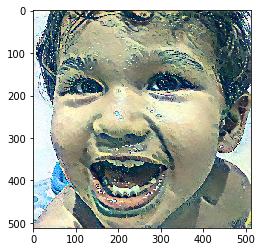

In [16]:
show_img(out,title='Output Image')
print(out)

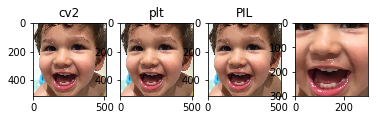

In [17]:

import cv2

img_path = './content.png'

# 使用cv2 读入的格式是b g r，而plt 和PIL默认是r g b
img = cv2.imread(img_path)
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])
plt.subplot(1,4,1)
plt.title('cv2')
plt.imshow(img)
 
#plt
img = plt.imread(img_path)
plt.subplot(1,4,2)
plt.title('plt')
plt.imshow(img)
 
#PIL
img = Image.open(img_path)
plt.subplot(1,4,3)
plt.title('PIL')
plt.imshow(img)

transform_test = transforms.Compose([
transforms.ToTensor(),
# from tensor to <class 'PIL.Image.Image'>
transforms.ToPILImage(),
transforms.RandomCrop((300,300)),
])

plt.subplot(1,4,4)
img = Image.open(img_path).convert('RGB')
 
img3 = transform_test(img)
plt.imshow(img3)